# 02 Huia Experience Training

### Reference
https://www.tensorflow.org/alpha/tutorials/load_data/images

## TODOS
- not using variable learning rates => keras extension --- 
- LRFinder
- interpret layers visually
- tensorboard convergence

# Setup 
## Install Tensorflow 2 Nightly

In [1]:
#!pip install --upgrade --force-reinstall tf-nightly-gpu-2.0-preview
#!pip install tfa-nightly
#!pip install tensorflow-addons
!pip freeze | grep tensor

tensorflow-addons==0.2.0.dev0
tensorflow-estimator-2.0-preview==1.14.0.dev2019042513
tensorflow-gpu==2.0.0a0
tensorflow-hub==0.3.0
tensorflowjs==1.0.1


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [4]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import pathlib
from pathlib import Path
import tensorboard as tb

# enable logging to make sure we are running on the GPU
#tf.debugging.set_log_device_placement(True)

In [5]:
# clear any active session
tf.keras.backend.clear_session()

AUTOTUNE = tf.data.experimental.AUTOTUNE
print(tf.__version__)
# print(tfa.__version__)

2.0.0-dev20190425


# Data
We have to understand well our data as this is fundamental to achieve good results.

In [6]:
root_path = pathlib.Path("./training_data/")
image_path = root_path /"images"
json_path = root_path /"json"
image_path,json_path

(PosixPath('training_data/images'), PosixPath('training_data/json'))

In [7]:
from matplotlib.image import imread
import numpy as np
import os

# open images and delete if they are empty
def remove_empty_imgs(imgpath):
    for item in imgpath.iterdir():
        im = imread(str(item), format='png')
        if np.count_nonzero(im)==0: 
            print(item,np.count_nonzero(im))
            os.remove(str(item))
            
#remove_empty_imgs(image_path)

In [8]:
# lets set the random seed so we can reproduce our results
import random
random.seed(7)

# get filenames from directories
all_image_paths = list(image_path.glob('*.png'))
all_json_paths = list(json_path.glob('*.json'))

all_image_paths = [str(path) for path in all_image_paths] # convert to strings
random.shuffle(all_image_paths) # randomize

In [9]:
len(all_image_paths), len(all_json_paths)

(328, 283)

In [10]:
# since we might delete unwanted images, this will also delete the json files
# sync json & images 

def sync_json_images(json_paths, img_path):
    for json in json_paths:
        #print(json.stem, end=" ")
        img = img_path/f"{json.stem}.png"
        if not Path(img).exists():
            print(f"{img} doesn't exist, deleting {json}")
            Path(json).unlink()
        
sync_json_images(all_json_paths, image_path)


In [11]:
all_image_paths[:20] 

['training_data/images/hadouken_262.png',
 'training_data/images/normal_17.png',
 'training_data/images/normal_403.png',
 'training_data/images/dramatic_556.png',
 'training_data/images/underarm_247.png',
 'training_data/images/fly_447.png',
 'training_data/images/moonwalk_894.png',
 'training_data/images/hadouken_979.png',
 'training_data/images/fly_48.png',
 'training_data/images/normal_803.png',
 'training_data/images/normal_6.png',
 'training_data/images/moonwalk_250.png',
 'training_data/images/wings_22.png',
 'training_data/images/hadouken_494.png',
 'training_data/images/hadouken_970.png',
 'training_data/images/fly_450.png',
 'training_data/images/moonwalk_882.png',
 'training_data/images/underarm_871.png',
 'training_data/images/moonwalk_87.png',
 'training_data/images/normal_5.png']

In [12]:
import re
# extract categories for classification
pat = r'/([^/]+)_\d+.png$'
all_image_labels = [str(re.search(pat,str(image)).group(1)).lower() for image in all_image_paths]
all_image_labels

['hadouken',
 'normal',
 'normal',
 'dramatic',
 'underarm',
 'fly',
 'moonwalk',
 'hadouken',
 'fly',
 'normal',
 'normal',
 'moonwalk',
 'wings',
 'hadouken',
 'hadouken',
 'fly',
 'moonwalk',
 'underarm',
 'moonwalk',
 'normal',
 'wings',
 'fly',
 'fly',
 'dramatic',
 'hadouken',
 'backpack',
 'dramatic',
 'dramatic',
 'wings',
 'backpack',
 'fly',
 'moonwalk',
 'normal',
 'underarm',
 'hadouken',
 'wings',
 'underarm',
 'fly',
 'moonwalk',
 'underarm',
 'normal',
 'fly',
 'hadouken',
 'fly',
 'backpack',
 'underarm',
 'wings',
 'moonwalk',
 'moonwalk',
 'underarm',
 'wings',
 'fly',
 'normal',
 'wings',
 'moonwalk',
 'fly',
 'moonwalk',
 'normal',
 'normal',
 'underarm',
 'hadouken',
 'backpack',
 'underarm',
 'fly',
 'fly',
 'wings',
 'hadouken',
 'fly',
 'dramatic',
 'dramatic',
 'fly',
 'fly',
 'underarm',
 'hadouken',
 'dramatic',
 'hadouken',
 'underarm',
 'normal',
 'backpack',
 'hadouken',
 'fly',
 'fly',
 'dramatic',
 'wings',
 'normal',
 'normal',
 'normal',
 'normal',
 'h

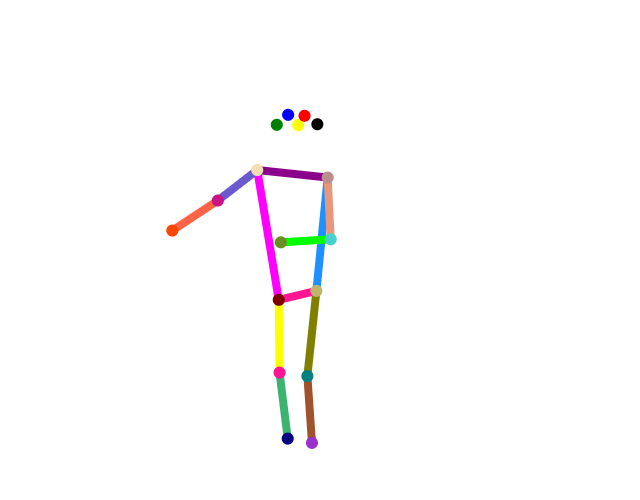

file: training_data/images/backpack_106.png


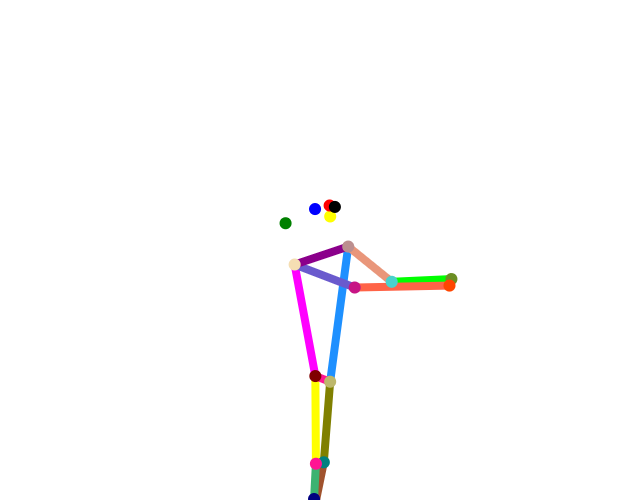

file: training_data/images/hadouken_970.png


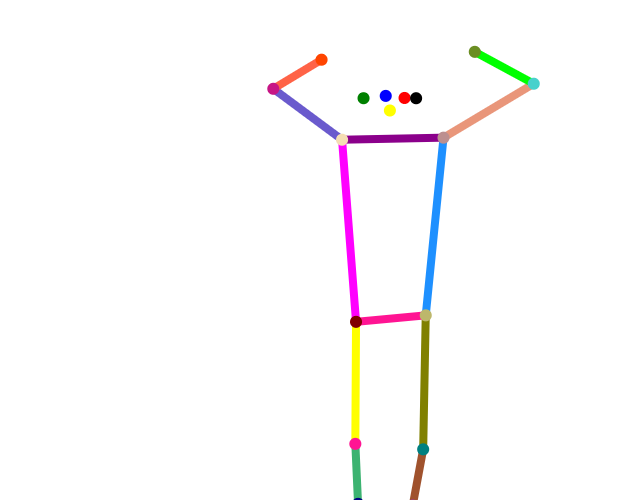

file: training_data/images/dramatic_293.png


In [13]:
import IPython.display as display
import math
import matplotlib.pyplot as plt

# lets check our images to see what they look like
for n in range(3):  
    image = random.choice(all_image_paths)
    display.display(display.Image(str(image)))
    print(f"file: {image}")


In [14]:
# get unique classes
huia_person=[]
for label in all_image_labels:
    if label not in huia_person:
        huia_person.append(label)
huia_person = sorted(huia_person) # sort label list
huia_person

['backpack',
 'dramatic',
 'fly',
 'hadouken',
 'moonwalk',
 'normal',
 'underarm',
 'wings']

In [15]:
label_to_index = dict((name, index) for index,name in enumerate(huia_person))
label_to_index

{'backpack': 0,
 'dramatic': 1,
 'fly': 2,
 'hadouken': 3,
 'moonwalk': 4,
 'normal': 5,
 'underarm': 6,
 'wings': 7}

In [16]:
# lets format it, so we can copy and paste the dict into javascript :-)
print("POSE_CLASSES = {")
for index,name in enumerate(huia_person):
    print(str(index)+": '"+name+"',")
print("}")

POSE_CLASSES = {
0: 'backpack',
1: 'dramatic',
2: 'fly',
3: 'hadouken',
4: 'moonwalk',
5: 'normal',
6: 'underarm',
7: 'wings',
}


(500, 640, 4)
<dtype: 'uint8'>


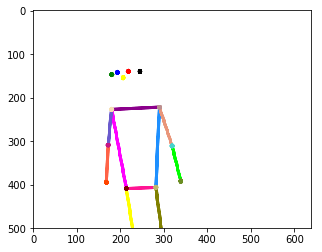

In [17]:
# load data into tf data
img_raw = tf.io.read_file(all_image_paths[1])
img_tensor = tf.image.decode_image(img_raw)
print(img_tensor.shape)
print(img_tensor.dtype)
plt.imshow(img_tensor)

In [18]:
from random import randint

# resize + normalize + data augmentation
def preprocess_image(image):
    # resize
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    #random crop    
    # tf.image.random_crop(image,[224,224,3],7)
    # random rotate
    degree_angle = random.randint(-2,2)
    radian = degree_angle * math.pi / 180
    image = tfa.image.rotate(image,radian) #,interpolation='BILINEAR')
    # normalize
    offset = 127.5;
    image = (image-offset)/offset  # convert to -1 : 1    
    return image

def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

#def train_preproccess(image,label):
    #image = tf.image.random_crop(image,[224,224,3])
    #image = tf.image.random_flip_left_right(image)
    #image = tf.keras.preprocessing.image.random_rotation(image,15)
    #image = tf.keras.preprocessing.image.random_zoom(image, 20)

In [19]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
path_ds

<TensorSliceDataset shapes: (), types: tf.string>

In [20]:
image_ds = path_ds.map(load_and_preprocess_image,num_parallel_calls = AUTOTUNE)
image_ds

W0501 16:08:20.791576 139921700771648 tf_logging.py:161] Entity <function image_projective_transform_v2 at 0x7f41894ef2f0> could not be transformed and will be executed as-is. Some features (e.g. tensor-dependent conditionals and loops) may not work as expected. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Unexpected error transforming <function image_projective_transform_v2 at 0x7f41894ef2f0>. If you believe this is due to a bug, please set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output when filing the bug report. Caused by: Unable to locate the source code of <function image_projective_transform_v2 at 0x7f41894ef2f0>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is grap

<ParallelMapDataset shapes: (224, 224, 3), types: tf.float32>

W0501 16:08:20.931084 139921700771648 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


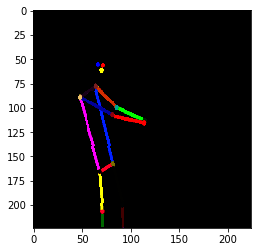

In [21]:
#!pip install Pillow
import matplotlib.pyplot as plt
from PIL import Image


## rotate images
# https://stackoverflow.com/questions/53273226/how-to-rotate-images-at-different-angles-randomly-in-tensorflow

for image in image_ds:
    #print(image)
    #print(type(image))
    #print(image.shape)
    #print(image.numpy().max())
    #im = image.numpy()
    #im=im[:,:,0]
    #print(im.shape)
    #im = Image.fromarray(image.numpy(), 'RGB')
    #im = tf.image.encode_png(im)
    #im = tf.image.convert_image_dtype(image,tf.float32)
    #print(im.max())
    #display.display(display.Image(image))
    #im.show()
    plt.imshow(image)
    break

In [22]:
all_image_labels_idx = [label_to_index[label] for label in all_image_labels]
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels_idx, tf.int64))

In [23]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
image_label_ds
image_count = len(all_image_labels)

type(image_label_ds)

tensorflow.python.data.ops.dataset_ops.ZipDataset

In [24]:
BATCH_SIZE = 32

ds = image_label_ds.cache()
ds = ds.apply(tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
#ds = tf.data.Dataset.shuffle(image_count, 7)
#ds = tf.data.Dataset.repeat(image_count)
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
ds

W0501 16:08:21.895557 139921700771648 deprecation.py:323] From <ipython-input-24-397004553403>:4: shuffle_and_repeat (from tensorflow.python.data.experimental.ops.shuffle_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [25]:
# we will use a pretrained mobilenet for transferlearning
mobilenet = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),include_top=False,weights='imagenet')
mobilenet.trainable = False
mobilenet.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [26]:
image_batch, label_batch = next(iter(ds))
print(image_batch.shape)
#image_batch[0]

(32, 224, 224, 3)


In [27]:
#label_batch[0].numpy()
#image_batch[0].numpy()

In [28]:
feature_map_batch = mobilenet(image_batch)
print(feature_map_batch.shape)

(32, 7, 7, 1280)


In [29]:
model = tf.keras.Sequential([
    mobilenet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1024,activation='relu',bias_initializer=tf.keras.initializers.he_normal()),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1024,activation='relu',bias_initializer=tf.keras.initializers.he_normal()),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512,activation='relu',bias_initializer=tf.keras.initializers.he_normal(),name='features'),
    tf.keras.layers.Dense(len(huia_person),activation='softmax'),
])
model.summary()
#mobilenet.summay()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0

In [30]:
logit_batch = model(image_batch).numpy()

print("min logit:", logit_batch.min())
print("max logit:", logit_batch.max())
print()

print("Shape:", logit_batch.shape)

min logit: 0.050538488
max logit: 0.30137742

Shape: (32, 8)


In [31]:
len(model.trainable_variables) 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0

In [32]:
steps_per_epoch=tf.math.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
steps_per_epoch

11.0

In [33]:
# class myCallback(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs={}):
#     if(logs.get('val_accuracy')>0.9):
#       print("\nReached 60% accuracy so cancelling training!")
#       self.model.stop_training = True

callbacks = []

#tbCallback = tf.keras.callbacks.TensorBoard(log_dir='./logs',histogram_freq=1,  embeddings_freq=1)
#tbCallback.set_model(model)
#callbacks.append(tbCallback)

# earlyStopping = tf.keras.callbacks.EarlyStopping(patience=2, monitor='loss')
# callbacks.append(earlyStopping)

# chkPoint = tf.keras.callbacks.ModelCheckpoint('./models.h5')
# chkPoint.set_model(model)
# callbacks.append(chkPoint)


In [34]:
#ds.shuffle(buffer_size=32)
test_dataset = ds.take(70) 
train_dataset = ds.skip(70)

In [35]:
mobilenet.trainable = False
model.compile(optimizer=tf.keras.optimizers.Adam(lr=3e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-07, amsgrad=False), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [36]:
model.fit(train_dataset, epochs=20,steps_per_epoch=steps_per_epoch,verbose=1,validation_data=test_dataset,
          callbacks=callbacks)

Epoch 1/20
11/11 [==============================] - 6s 578ms/step - loss: 1.8765 - accuracy: 0.3466 - val_loss: 1.8050 - val_accuracy: 0.3636
Epoch 2/20
11/11 [==============================] - 2s 212ms/step - loss: 1.2632 - accuracy: 0.6335 - val_loss: 1.4600 - val_accuracy: 0.4432
Epoch 3/20
11/11 [==============================] - 2s 212ms/step - loss: 0.7488 - accuracy: 0.7699 - val_loss: 1.7872 - val_accuracy: 0.3267
Epoch 4/20
11/11 [==============================] - 2s 210ms/step - loss: 0.4099 - accuracy: 0.8722 - val_loss: 1.5380 - val_accuracy: 0.4545
Epoch 5/20
11/11 [==============================] - 2s 212ms/step - loss: 0.2383 - accuracy: 0.9347 - val_loss: 1.7039 - val_accuracy: 0.4119
Epoch 6/20
11/11 [==============================] - 2s 211ms/step - loss: 0.2014 - accuracy: 0.9290 - val_loss: 1.8224 - val_accuracy: 0.5199
Epoch 7/20
11/11 [==============================] - 2s 213ms/step - loss: 0.1591 - accuracy: 0.9574 - val_loss: 0.9241 - val_accuracy: 0.6364
Epoch 

In [43]:
mobilenet.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(lr=3e-6, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-07, amsgrad=False), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [44]:
model.fit(train_dataset, epochs=300,steps_per_epoch=steps_per_epoch,verbose=1,validation_data=test_dataset,
          callbacks=callbacks)

Epoch 1/300
11/11 [==============================] - 32s 3s/step - loss: 0.0081 - accuracy: 0.9972 - val_loss: 2.1070 - val_accuracy: 0.4830
Epoch 2/300
11/11 [==============================] - 4s 334ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 2.0740 - val_accuracy: 0.4801
Epoch 3/300
11/11 [==============================] - 4s 339ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 2.0290 - val_accuracy: 0.4886
Epoch 4/300
11/11 [==============================] - 4s 339ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 1.9959 - val_accuracy: 0.4773
Epoch 5/300
11/11 [==============================] - 4s 330ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 1.9720 - val_accuracy: 0.4659
Epoch 6/300
11/11 [==============================] - 4s 332ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.9245 - val_accuracy: 0.4688
Epoch 7/300
11/11 [==============================] - 4s 334ms/step - loss: 0.0095 - accuracy: 0.9972 - val_loss: 1.9496 - val_accuracy: 0.4688
E

Epoch 58/300
11/11 [==============================] - 4s 340ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 1.3827 - val_accuracy: 0.6250
Epoch 59/300
11/11 [==============================] - 4s 345ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.3742 - val_accuracy: 0.6250
Epoch 60/300
11/11 [==============================] - 4s 339ms/step - loss: 8.6231e-04 - accuracy: 1.0000 - val_loss: 1.3658 - val_accuracy: 0.6335
Epoch 61/300
11/11 [==============================] - 4s 349ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.3598 - val_accuracy: 0.6335
Epoch 62/300
11/11 [==============================] - 4s 337ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.3379 - val_accuracy: 0.6392
Epoch 63/300
11/11 [==============================] - 4s 334ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.3346 - val_accuracy: 0.6392
Epoch 64/300
11/11 [==============================] - 4s 334ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 1.3472 - val_accur

Epoch 114/300
11/11 [==============================] - 4s 335ms/step - loss: 4.4546e-04 - accuracy: 1.0000 - val_loss: 0.7497 - val_accuracy: 0.7727
Epoch 115/300
11/11 [==============================] - 4s 333ms/step - loss: 2.2834e-04 - accuracy: 1.0000 - val_loss: 0.7376 - val_accuracy: 0.7812
Epoch 116/300
11/11 [==============================] - 4s 336ms/step - loss: 3.3742e-04 - accuracy: 1.0000 - val_loss: 0.7285 - val_accuracy: 0.7784
Epoch 117/300
11/11 [==============================] - 4s 350ms/step - loss: 4.7247e-04 - accuracy: 1.0000 - val_loss: 0.7182 - val_accuracy: 0.7756
Epoch 118/300
11/11 [==============================] - 4s 340ms/step - loss: 4.1123e-04 - accuracy: 1.0000 - val_loss: 0.7116 - val_accuracy: 0.7699
Epoch 119/300
11/11 [==============================] - 4s 358ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.7198 - val_accuracy: 0.7670
Epoch 120/300
11/11 [==============================] - 4s 346ms/step - loss: 1.7428e-04 - accuracy: 1.0000 - v

11/11 [==============================] - 4s 338ms/step - loss: 2.7382e-04 - accuracy: 1.0000 - val_loss: 0.3600 - val_accuracy: 0.8608
Epoch 170/300
11/11 [==============================] - 4s 346ms/step - loss: 1.5376e-04 - accuracy: 1.0000 - val_loss: 0.3553 - val_accuracy: 0.8608
Epoch 171/300
11/11 [==============================] - 4s 333ms/step - loss: 1.9445e-04 - accuracy: 1.0000 - val_loss: 0.3502 - val_accuracy: 0.8608
Epoch 172/300
11/11 [==============================] - 4s 334ms/step - loss: 6.5705e-04 - accuracy: 1.0000 - val_loss: 0.3482 - val_accuracy: 0.8636
Epoch 173/300
11/11 [==============================] - 4s 337ms/step - loss: 3.9875e-04 - accuracy: 1.0000 - val_loss: 0.3460 - val_accuracy: 0.8665
Epoch 174/300
11/11 [==============================] - 4s 344ms/step - loss: 2.8565e-04 - accuracy: 1.0000 - val_loss: 0.3429 - val_accuracy: 0.8722
Epoch 175/300
11/11 [==============================] - 4s 350ms/step - loss: 6.5700e-04 - accuracy: 1.0000 - val_loss: 0

11/11 [==============================] - 4s 335ms/step - loss: 3.2598e-04 - accuracy: 1.0000 - val_loss: 0.0957 - val_accuracy: 0.9574
Epoch 225/300
11/11 [==============================] - 4s 337ms/step - loss: 1.0021e-04 - accuracy: 1.0000 - val_loss: 0.0930 - val_accuracy: 0.9574
Epoch 226/300
11/11 [==============================] - 4s 336ms/step - loss: 3.8491e-04 - accuracy: 1.0000 - val_loss: 0.0889 - val_accuracy: 0.9602
Epoch 227/300
11/11 [==============================] - 4s 347ms/step - loss: 4.0459e-04 - accuracy: 1.0000 - val_loss: 0.0850 - val_accuracy: 0.9602
Epoch 228/300
11/11 [==============================] - 4s 341ms/step - loss: 1.4421e-04 - accuracy: 1.0000 - val_loss: 0.0809 - val_accuracy: 0.9631
Epoch 229/300
11/11 [==============================] - 4s 343ms/step - loss: 1.4634e-04 - accuracy: 1.0000 - val_loss: 0.0765 - val_accuracy: 0.9659
Epoch 230/300
11/11 [==============================] - 4s 346ms/step - loss: 2.8963e-04 - accuracy: 1.0000 - val_loss: 0

11/11 [==============================] - 4s 349ms/step - loss: 1.0666e-04 - accuracy: 1.0000 - val_loss: 0.0197 - val_accuracy: 0.9943
Epoch 280/300
11/11 [==============================] - 4s 337ms/step - loss: 9.3196e-05 - accuracy: 1.0000 - val_loss: 0.0186 - val_accuracy: 0.9943
Epoch 281/300
11/11 [==============================] - 4s 345ms/step - loss: 3.0507e-05 - accuracy: 1.0000 - val_loss: 0.0174 - val_accuracy: 0.9943
Epoch 282/300
11/11 [==============================] - 4s 338ms/step - loss: 1.5584e-04 - accuracy: 1.0000 - val_loss: 0.0162 - val_accuracy: 0.9943
Epoch 283/300
11/11 [==============================] - 4s 339ms/step - loss: 6.5580e-04 - accuracy: 1.0000 - val_loss: 0.0146 - val_accuracy: 0.9943
Epoch 284/300
11/11 [==============================] - 4s 333ms/step - loss: 1.5130e-04 - accuracy: 1.0000 - val_loss: 0.0130 - val_accuracy: 0.9943
Epoch 285/300
11/11 [==============================] - 4s 335ms/step - loss: 2.1358e-04 - accuracy: 1.0000 - val_loss: 0

In [39]:
model.save("models/huia_mob_224_teste_10.h5") # 1.0

In [40]:
model

In [41]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, "models_tfjs/tfjs_huia_mob_224_teste_10_q",quantization_dtype=np.uint16)

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0

In [ ]:
tf.keras.utils.plot_model(model,'model.png',show_layer_names=False) #,show_shapes=True)

In [ ]:
%load_ext tensorboard.notebook

#notebook.list() # View open TensorBoard instances
#notebook.display(port=6006, height=1000)

In [ ]:
#!kill 25264
%tensorboard --logdir ./logs

In [ ]:
import time
default_timeit_steps = 2*steps_per_epoch+1

def timeit(ds, steps=default_timeit_steps):
  overall_start = time.time()
  # Fetch a single batch to prime the pipeline (fill the shuffle buffer),
  # before starting the timer
  it = iter(ds.take(steps+1))
  next(it)

  start = time.time()
  for i,(images,labels) in enumerate(it):
    if i%10 == 0:
      print('.',end='')
  print()
  end = time.time()

  duration = end-start
  print("{} batches: {} s".format(steps, duration))
  print("{:0.5f} Images/s".format(BATCH_SIZE*steps/duration))
  print("Total time: {}s".format(end-overall_start))

In [ ]:
timeit(ds)

# Predict

In [ ]:
import numpy as np
sample = np.reshape(img_final,[1,224,224,3])

predict = int(model.predict_classes(sample))
predict

In [ ]:
[key for key,value in label_to_index.items() if value == predict]

In [ ]:
label_to_index